In [106]:
import pandas as pd
import numpy as np
import scipy as sp
import random
import scipy.stats
import math
import statistics
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller

In [107]:
df = pd.read_csv(r"london_weather.csv")
df = df.drop(np.arange(3040,len(df)))
df = df[["date","mean_temp"]]
df = df.dropna()
df.insert(0,"index",np.arange(len(df)))
df = df.reset_index()
df.set_index("index")
df

,level_0,index,date,mean_temp
0,0,0,19790101,-4.1
1,1,1,19790102,-2.6
2,2,2,19790103,-2.8
3,3,3,19790104,-2.6
4,4,4,19790105,-0.8
...,...,...,...,...
3035,3035,3035,19870424,14.8
3036,3036,3036,19870425,15.0
3037,3037,3037,19870426,15.1
3038,3038,3038,19870427,15.6


In [108]:
t = df["index"]
temp = df["mean_temp"]

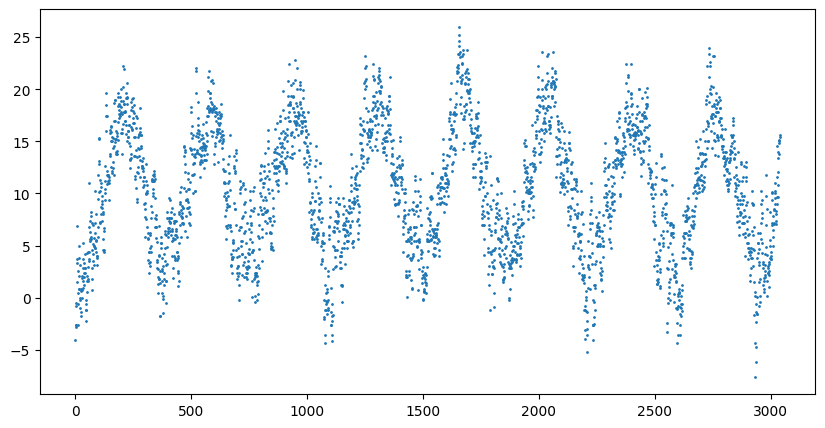

In [109]:
plt.figure(figsize = (10,5))
plt.scatter(t,temp,s=1)
#plt.xlabel("PKB na osobę")
#plt.ylabel("poziom szczęścia")
#plt.title("Wykres zależności poziomu szczęścia od PKB na osobę")

#plt.savefig('plot1.pdf', format='pdf')

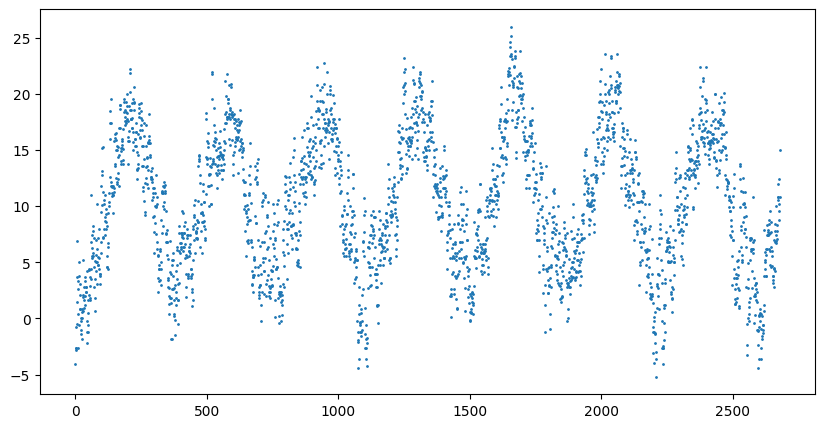

In [110]:
train = df[:2680]
test = df.drop(train.index)
plt.figure(figsize = (10,5))
plt.scatter(train["index"],train["mean_temp"],s=1)

train_t = train["index"]
train_temp = train["mean_temp"]

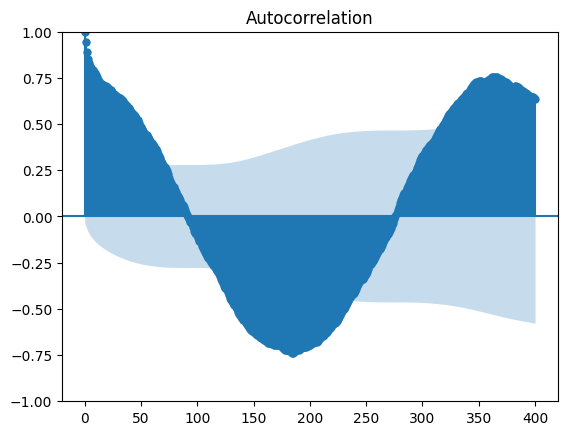

In [174]:
h = 400
plot_acf(train_temp, lags=h, adjusted=True)
plt.show()

In [111]:
#dekompozycja liniowości
a,b = np.linalg.lstsq(np.vstack([train_t, np.ones(len(train_t))]).T, train_temp, rcond=None)[0]

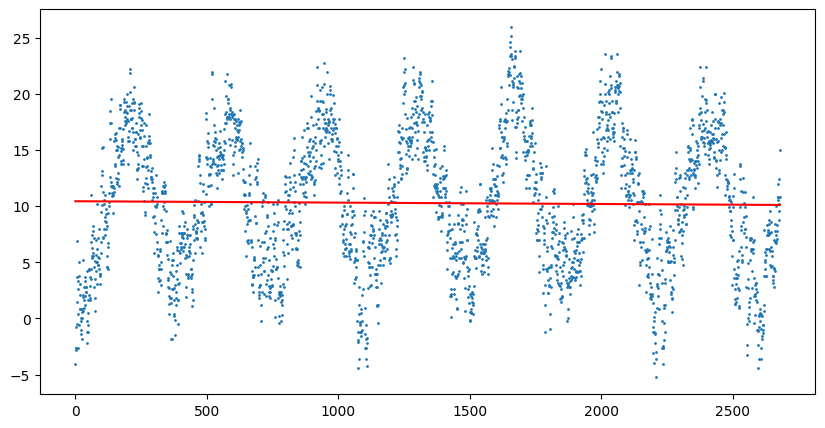

In [112]:
plt.figure(figsize = (10,5))
plt.scatter(train_t,train_temp,s=1)
plt.plot(train_t,a*train_t+b,"r")

In [113]:
train_temp_2 = []
for i in range(len(train)):
    train_temp_2.append(train_temp[i] - a*train_t[i] - b)

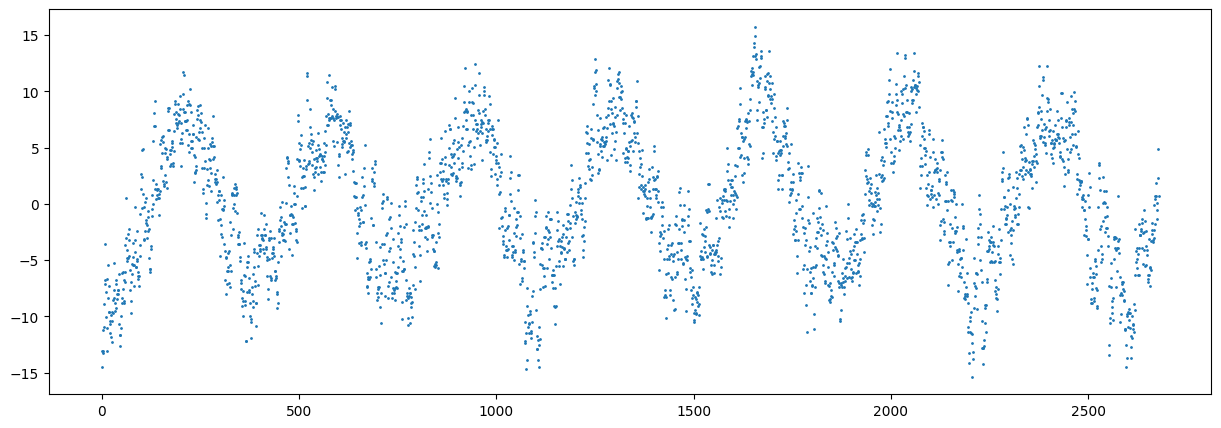

In [114]:
plt.figure(figsize = (15,5))
plt.scatter(train_t,train_temp_2,s=1)

In [115]:
def func(t, c, d, e):
    return c* np.sin(d*t + e)

Q = np.quantile(train_temp_2, 0.9)
p0 = [Q,1/(350/1/(2*np.pi)),np.random.random()]
c_est, d_est, e_est = sp.optimize.curve_fit(func, xdata = train_t, ydata = train_temp_2,p0=p0,bounds = ((Q,0,0),(40,np.inf,10)))[0]

In [116]:
c_est, d_est, e_est

(7.728554594047391, 0.017155852893729912, 4.333763703422037)

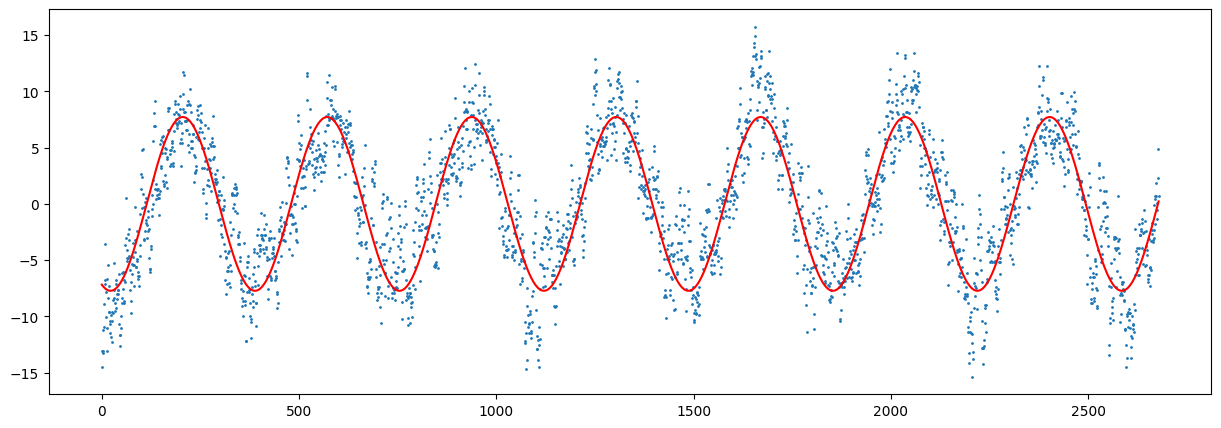

In [117]:
plt.figure(figsize = (15,5))
plt.scatter(train_t,train_temp_2,s=1)
plt.plot(train_t,func(train_t,c_est, d_est, e_est),"r")

In [118]:
train_temp_3 = []
for i in range(len(train)):
    train_temp_3.append(train_temp_2[i] - c_est* np.sin(d_est*train_t[i] + e_est))

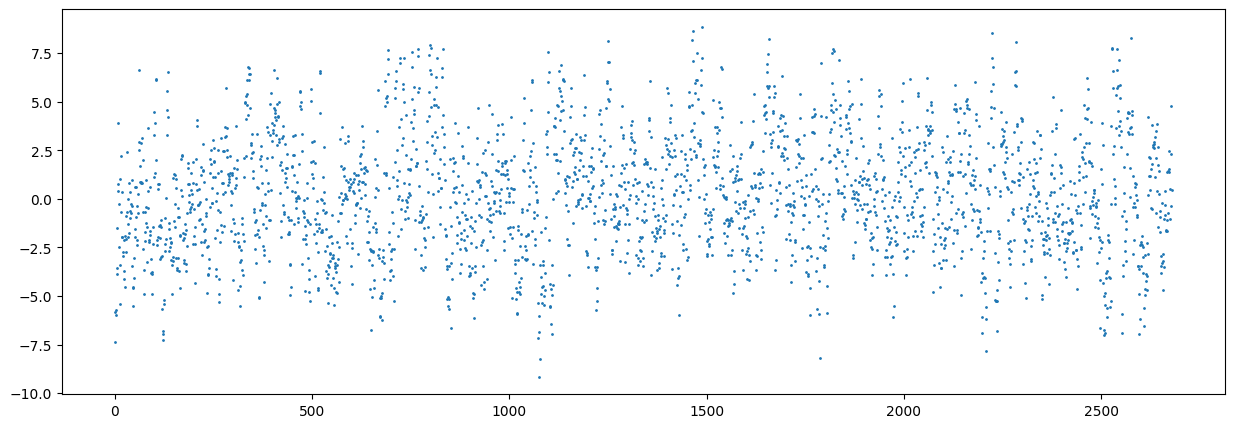

In [119]:
plt.figure(figsize = (15,5))
plt.scatter(train_t,train_temp_3,s=1)

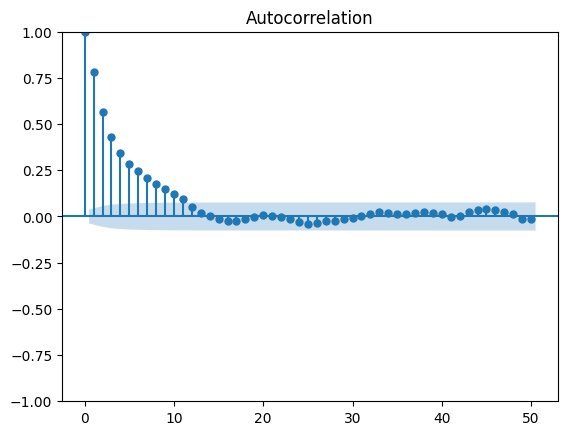

In [120]:
h = 50
plot_acf(train_temp_3, lags=h, adjusted=True)
plt.show()

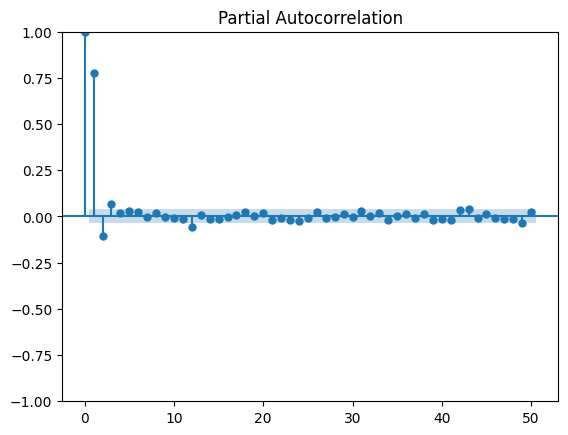

In [121]:
plot_pacf(train_temp_3, lags=h, method='ywm')
plt.show()

In [128]:
data = train_temp_3

df = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 10
max_q = 10

for p in range(0, max_p):
    for q in range(0, max_q):
        model = ARIMA(data, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

C:\Users\Natalia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Natalia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Natalia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Natalia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

C:\Users\Natalia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Natalia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Natalia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Natalia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

In [176]:
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
56,5,6,10933.960861,11010.577298,10961.678129
78,7,8,10934.090625,11034.281350,10970.336283
97,9,7,10934.984168,11041.068465,10973.361923
79,7,9,10935.015702,11041.100000,10973.393458
44,4,4,10935.166047,10994.101768,10956.487023


In [177]:
df.sort_values(by='BIC').head()

,p,q,AIC,BIC,HQIC
11,1,1,10945.997929,10969.572218,10954.526320
30,3,0,10940.398608,10969.866469,10951.059096
12,1,2,10941.710972,10971.178832,10952.371459
21,2,1,10944.132071,10973.599931,10954.792559
22,2,2,10938.737268,10974.098700,10951.529853


In [178]:
df.sort_values(by='HQIC').head()

,p,q,AIC,BIC,HQIC
30,3,0,10940.398608,10969.866469,10951.059096
22,2,2,10938.737268,10974.098700,10951.529853
31,3,1,10938.935705,10974.297137,10951.728290
12,1,2,10941.710972,10971.178832,10952.371459
13,1,3,10940.538468,10975.899900,10953.331053


In [160]:
p, q = 1, 1

model = ARIMA(train_temp_3, order=(p, 0, q)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2680
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5468.999
Date:                Wed, 08 Feb 2023   AIC                          10945.998
Time:                        16:53:35   BIC                          10969.572
Sample:                             0   HQIC                         10954.526
                               - 2680                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2230      0.150      1.486      0.137      -0.071       0.517
ar.L1          0.7205      0.017     42.821      0.000       0.687       0.753
ma.L1          0.1546      0.023      6.580      0.0

In [163]:
resid = model.resid
params = model.params

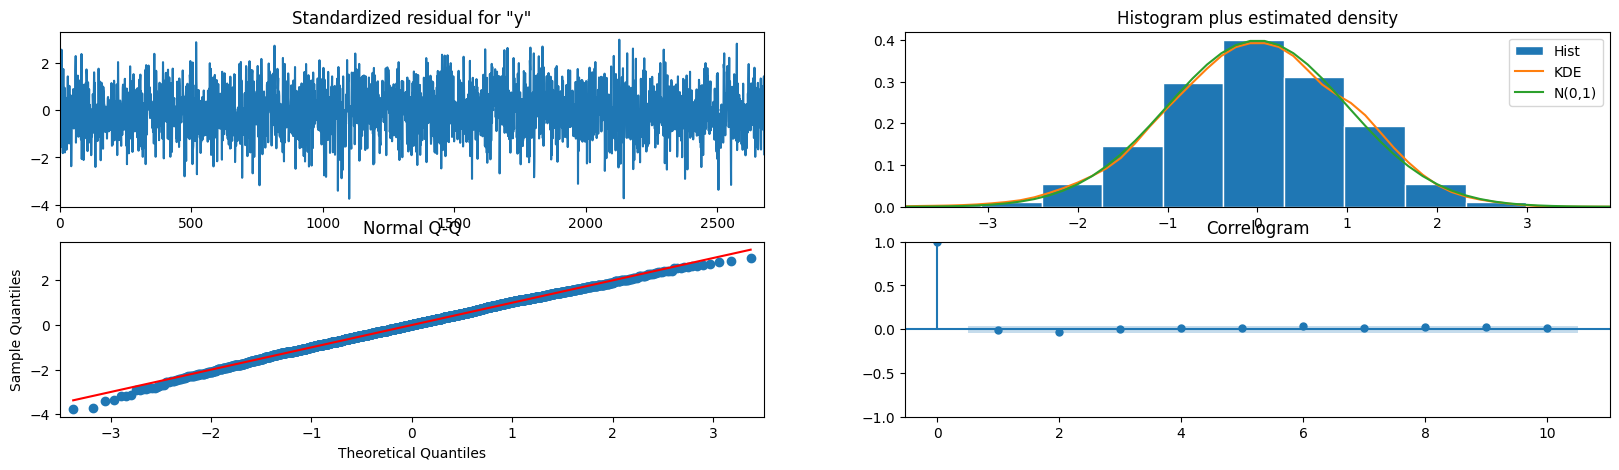

In [164]:
model.plot_diagnostics(0,figsize=(20,5))
plt.plot();

Średnia

In [166]:
scipy.stats.ttest_1samp(resid, popmean=0)

Ttest_1sampResult(statistic=0.04706184306961072, pvalue=0.9624674462497231)

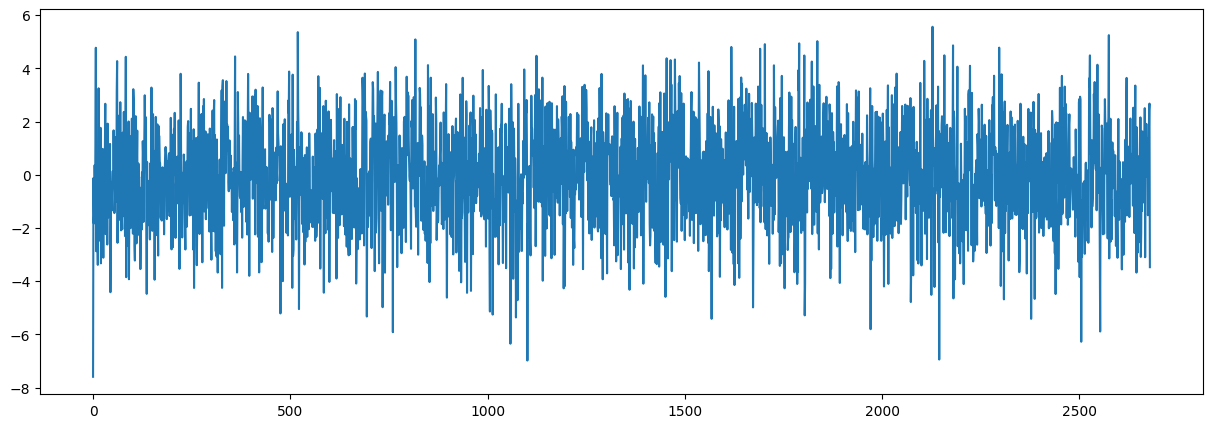

In [169]:
plt.figure(figsize = (15,5))
plt.plot(train_t,resid)

Wariancja